In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# standard imports
from tensorflow import keras
import numpy as np
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras import layers
import random
from sklearn import preprocessing
from keras.callbacks import History
import matplotlib.pyplot as plt
from keras.utils import np_utils
import os
from tensorflow.keras.optimizers import Adam
from plain_neural_network import*
from keras import backend as K

%matplotlib inline

2022-07-02 09:08:09.605731: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-07-02 09:08:09.605764: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
input_dir = "/home/ollie/ssunar/ssh_filtered"
input_file_paths = sorted(
    [
        os.path.join(input_dir, fname)
        for fname in os.listdir(input_dir)
    ])
input_file_paths.pop(29)
input_file_paths.pop(11)

data_x = xr.open_mfdataset(input_file_paths,combine = 'nested', concat_dim="TIME")
data_x = data_x.ssh.to_numpy()
X = np.float32(data_x)
                            
X[X>1000] = 0
print(X.shape)

'/home/ollie/ssunar/ssh_filtered/ssh_gridded_1963_001_06_new.nc'

'/home/ollie/ssunar/ssh_filtered/ssh_gridded_1961_001_12_new.nc'

(1034, 1200, 480)


In [3]:
input_dir = "/home/ollie/ssunar/segmentation_masks_3_years"
input_file_paths = sorted(
    [
        os.path.join(input_dir, fname)
        for fname in os.listdir(input_dir)
    ])
input_file_paths.pop(29)
input_file_paths.pop(11)

data_y = xr.open_mfdataset(input_file_paths,combine = 'nested', concat_dim="TIME")
data_y = data_y.seg_mask.to_numpy()
Y = np.float32(data_y)
print(Y.shape)

'/home/ollie/ssunar/segmentation_masks_3_years/segmentation_mask_nn_1963_001_06_new.nc'

'/home/ollie/ssunar/segmentation_masks_3_years/segmentation_mask_nn_1961_001_12_new.nc'

(1034, 1200, 480)


In [4]:
X = X[0:365]
Y = Y[0:365]

In [5]:
temp_x_1 = X[:,0:256, 0:256]
temp_x_2 = X[:,0:256, 224:480]
temp_y_1 = Y[:,0:256, 0:256]
temp_y_2 = Y[:,0:256, 224:480]
data_x = np.concatenate((temp_x_1,temp_x_2), axis=0)
data_y = np.concatenate((temp_y_1,temp_y_2), axis=0)

for i in range(1,4):
    temp_x_1 = X[:,256*i:256*(i+1), 0:256]
    temp_x_2 = X[:,256*i:256*(i+1), 224:480]
    temp_y_1 = Y[:,256*i:256*(i+1), 0:256]
    temp_y_2 = Y[:,256*i:256*(i+1), 224:480]
    data_x = np.concatenate((data_x, np.concatenate((temp_x_1,temp_x_2), axis=0)), axis=0)
    data_y = np.concatenate((data_y, np.concatenate((temp_y_1,temp_y_2), axis=0)), axis=0)
    
print("Shape of data X:", data_x.shape)  
print("Shape of data Y:",data_y.shape)

Shape of data X: (2920, 256, 256)
Shape of data Y: (2920, 256, 256)


In [6]:
"""
data_x_1 = data_x
data_y_1 = data_y

#only using a portion of data from this region
used_split = 0.4
used_samples = int(used_split*len(data_x))
#same seed must be used
random.Random(0).shuffle(data_x)
random.Random(0).shuffle(data_y)
data_x_1 = data_x[0:used_samples]
data_y_1 = data_y[0:used_samples]
"""

'\ndata_x_1 = data_x\ndata_y_1 = data_y\n\n#only using a portion of data from this region\nused_split = 0.4\nused_samples = int(used_split*len(data_x))\n#same seed must be used\nrandom.Random(0).shuffle(data_x)\nrandom.Random(0).shuffle(data_y)\ndata_x_1 = data_x[0:used_samples]\ndata_y_1 = data_y[0:used_samples]\n'

In [7]:
"""
input_dir = "/work/ollie/bpanthi/NN_gulf/"
input_file_paths = sorted(
    [
        os.path.join(input_dir, fname)
        for fname in os.listdir(input_dir)
    ])
input_file_paths.pop(6)
data_x_2 = xr.open_mfdataset(input_file_paths,combine = 'nested', concat_dim="TIME")
data_x_2 = data_x_2.ssh.to_numpy()
data_x_2 = np.float32(data_x_2)
                            
data_x_2[data_x_2>1000] = 0
data_x_2 = data_x_2[:,52:308, 52:308]
print(data_x_2.shape)

input_dir = "/home/ollie/ssunar/segmentation_masks_NN_gulf"
input_file_paths = sorted(
    [
        os.path.join(input_dir, fname)
        for fname in os.listdir(input_dir)
    ])
input_file_paths.pop(6)
data_y_2 = xr.open_mfdataset(input_file_paths,combine = 'nested', concat_dim="TIME")
data_y_2 = data_y_2.seg_mask.to_numpy()
data_y_2 = np.float32(data_y_2)
data_y_2 = data_y_2[:,52:308, 52:308]
print(data_y_2.shape)
"""

'\ninput_dir = "/work/ollie/bpanthi/NN_gulf/"\ninput_file_paths = sorted(\n    [\n        os.path.join(input_dir, fname)\n        for fname in os.listdir(input_dir)\n    ])\ninput_file_paths.pop(6)\ndata_x_2 = xr.open_mfdataset(input_file_paths,combine = \'nested\', concat_dim="TIME")\ndata_x_2 = data_x_2.ssh.to_numpy()\ndata_x_2 = np.float32(data_x_2)\n                            \ndata_x_2[data_x_2>1000] = 0\ndata_x_2 = data_x_2[:,52:308, 52:308]\nprint(data_x_2.shape)\n\ninput_dir = "/home/ollie/ssunar/segmentation_masks_NN_gulf"\ninput_file_paths = sorted(\n    [\n        os.path.join(input_dir, fname)\n        for fname in os.listdir(input_dir)\n    ])\ninput_file_paths.pop(6)\ndata_y_2 = xr.open_mfdataset(input_file_paths,combine = \'nested\', concat_dim="TIME")\ndata_y_2 = data_y_2.seg_mask.to_numpy()\ndata_y_2 = np.float32(data_y_2)\ndata_y_2 = data_y_2[:,52:308, 52:308]\nprint(data_y_2.shape)\n'

In [8]:
"""
input_dir = "/work/ollie/bpanthi/NN_kursaal/"
input_file_paths = sorted(
    [
        os.path.join(input_dir, fname)
        for fname in os.listdir(input_dir)
    ])

data_x_3 = xr.open_mfdataset(input_file_paths,combine = 'nested', concat_dim="TIME")
data_x_3 = data_x_3.ssh.to_numpy()
data_x_3 = np.float32(data_x_3)
                            
data_x_3[data_x_3>1000] = 0
data_x_3 = data_x_3[:,52:308, 52:308]
print(data_x_3.shape)

input_dir = "/home/ollie/ssunar/segmentation_masks_NN_kursaal"
input_file_paths = sorted(
    [
        os.path.join(input_dir, fname)
        for fname in os.listdir(input_dir)
    ])
data_y_3 = xr.open_mfdataset(input_file_paths,combine = 'nested', concat_dim="TIME")
data_y_3 = data_y_3.seg_mask.to_numpy()
data_y_3 = np.float32(data_y_3)
data_y_3 = data_y_3[:,52:308, 52:308]
print(data_y_3.shape)
"""

'\ninput_dir = "/work/ollie/bpanthi/NN_kursaal/"\ninput_file_paths = sorted(\n    [\n        os.path.join(input_dir, fname)\n        for fname in os.listdir(input_dir)\n    ])\n\ndata_x_3 = xr.open_mfdataset(input_file_paths,combine = \'nested\', concat_dim="TIME")\ndata_x_3 = data_x_3.ssh.to_numpy()\ndata_x_3 = np.float32(data_x_3)\n                            \ndata_x_3[data_x_3>1000] = 0\ndata_x_3 = data_x_3[:,52:308, 52:308]\nprint(data_x_3.shape)\n\ninput_dir = "/home/ollie/ssunar/segmentation_masks_NN_kursaal"\ninput_file_paths = sorted(\n    [\n        os.path.join(input_dir, fname)\n        for fname in os.listdir(input_dir)\n    ])\ndata_y_3 = xr.open_mfdataset(input_file_paths,combine = \'nested\', concat_dim="TIME")\ndata_y_3 = data_y_3.seg_mask.to_numpy()\ndata_y_3 = np.float32(data_y_3)\ndata_y_3 = data_y_3[:,52:308, 52:308]\nprint(data_y_3.shape)\n'

In [9]:
"""
data_x = np.concatenate((data_x_1, np.concatenate((data_x_2,data_x_3), axis=0)), axis=0)
data_y = np.concatenate((data_y_1, np.concatenate((data_y_2,data_y_3), axis=0)), axis=0)
print(data_x.shape)
print(data_y.shape)
"""

'\ndata_x = np.concatenate((data_x_1, np.concatenate((data_x_2,data_x_3), axis=0)), axis=0)\ndata_y = np.concatenate((data_y_1, np.concatenate((data_y_2,data_y_3), axis=0)), axis=0)\nprint(data_x.shape)\nprint(data_y.shape)\n'

In [10]:
img_size = (256, 256)
num_classes = 3
batch_size = 16
epochs = 60
total_samples = len(data_x)
print(total_samples)

2920


In [11]:
model = get_model(img_size, num_classes)
model.summary()

2022-07-02 09:08:33.031243: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-07-02 09:08:33.031292: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-07-02 09:08:33.031337: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (prod-0285): /proc/driver/nvidia/version does not exist
2022-07-02 09:08:33.031585: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 1  0           []                               
                                )]                                                                
                                                                                                  
 separable_conv2d (SeparableCon  (None, 256, 256, 16  25         ['input_1[0][0]']                
 v2D)                           )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 256, 256, 16  64         ['separable_conv2d[0][0]']       
 alization)                     )                                                             

                                                                                                  
 batch_normalization_7 (BatchNo  (None, 32, 32, 32)  128         ['separable_conv2d_7[0][0]']     
 rmalization)                                                                                     
                                                                                                  
 activation_7 (Activation)      (None, 32, 32, 32)   0           ['batch_normalization_7[0][0]']  
                                                                                                  
 dropout_3 (Dropout)            (None, 32, 32, 32)   0           ['activation_7[0][0]']           
                                                                                                  
 up_sampling2d (UpSampling2D)   (None, 64, 64, 32)   0           ['dropout_3[0][0]']              
                                                                                                  
 concatena

                                )                                                                 
                                                                                                  
 separable_conv2d_14 (Separable  (None, 256, 256, 3)  64         ['dropout_6[0][0]']              
 Conv2D)                                                                                          
                                                                                                  
 reshape (Reshape)              (None, 65536, 3)     0           ['separable_conv2d_14[0][0]']    
                                                                                                  
 activation_14 (Activation)     (None, 65536, 3)     0           ['reshape[0][0]']                
                                                                                                  
Total params: 13,897
Trainable params: 13,257
Non-trainable params: 640
_____________________________________

In [12]:
#Loss function 
#defined from the paper:
#Santana et al._2020_Neural network training for the detection and classification of oceanic mesoscale eddies

unique, counts = np.unique(data_y, return_counts=True)
dict(zip(unique, counts))

freq = [np.sum(counts)/j for j in counts]
weightsSeg = [f/np.sum(freq) for f in freq]
print(weightsSeg)

def dice_coef_anti(y_true, y_pred):
    smooth = 1.  # to avoid zero division
    y_true_anti = y_true[:,:,1]
    y_pred_anti = y_pred[:,:,1]
    intersection_anti = K.sum(y_true_anti * y_pred_anti)
    return (2 * intersection_anti + smooth) / (K.sum(y_true_anti)+ K.sum(y_pred_anti) + smooth)

def dice_coef_cyc(y_true, y_pred):
    smooth = 1.  # to avoid zero division
    y_true_cyc = y_true[:,:,2]
    y_pred_cyc = y_pred[:,:,2]
    intersection_cyc = K.sum(y_true_cyc * y_pred_cyc)
    return (2 * intersection_cyc + smooth) / (K.sum(y_true_cyc) + K.sum(y_pred_cyc) + smooth)

def dice_coef_nn(y_true, y_pred):
    smooth = 1.  # to avoid zero division
    y_true_nn = y_true[:,:,0]
    y_pred_nn = y_pred[:,:,0]
    intersection_nn = K.sum(y_true_nn * y_pred_nn)
    return (2 * intersection_nn + smooth) / (K.sum(y_true_nn) + K.sum(y_pred_nn) + smooth)
    
def mean_dice_coef(y_true, y_pred):
    return (dice_coef_anti(y_true, y_pred) + dice_coef_cyc(y_true, y_pred) + dice_coef_nn(y_true, y_pred))/3.

def weighted_mean_dice_coef(y_true, y_pred):
    #return (weightsSeg[2]*dice_coef_anti(y_true, y_pred) + weightsSeg[1]*dice_coef_cyc(y_true, y_pred) + weightsSeg[0]*dice_coef_nn(y_true, y_pred))
    return (weightsSeg[2]*dice_coef_anti(y_true, y_pred) + weightsSeg[1]*dice_coef_cyc(y_true, y_pred) + weightsSeg[0]*dice_coef_nn(y_true, y_pred))
      
def dice_coef_loss(y_true, y_pred):
    return 1 - weighted_mean_dice_coef(y_true, y_pred)

{0.0: 173491229, 1.0: 9002024, 2.0: 8871867}

[0.025108166095129312, 0.4838963541732521, 0.49099547973161856]


In [13]:
# Split our img paths into a training and a validation set
split = 0.2
train_samples = int((1-split)*total_samples)
#same seed must be used
random.Random(0).shuffle(data_x)
random.Random(0).shuffle(data_y)
train_input = data_x[0:train_samples]
train_target = data_y[0:train_samples]
val_input = data_x[train_samples:total_samples]
val_target = data_y[train_samples:total_samples]

print("train_input:", train_input.shape)
print("val_input:", val_input.shape)

# Instantiate data Sequences for each split
train_gen = plain_net_eddy(batch_size, img_size, train_input, train_target)
val_gen = plain_net_eddy(batch_size, img_size, val_input, val_target)
print("Size of each batch: ",train_gen[1][0].shape)

train_input: (2336, 256, 256)
val_input: (584, 256, 256)
Size of each batch:  (16, 256, 256, 1)


In [14]:
file_path_save = "/home/ollie/ssunar/weights_filter_new/weights"
model.compile(optimizer=Adam(lr=1e-3), loss=dice_coef_loss, metrics=['categorical_accuracy', mean_dice_coef, weighted_mean_dice_coef])

callbacks = [keras.callbacks.ModelCheckpoint(file_path_save, save_best_only=True , monitor='val_loss',save_weights_only=True),
            keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, verbose=1, mode='auto', min_delta=1e-30, min_lr=1e-30)]

# Train the model, doing validation at the end of each epoch.
history = model.fit(train_gen, epochs=epochs, validation_data=val_gen, callbacks=callbacks, shuffle=True,verbose=1)

Epoch 1/60


/home/ollie/ssunar/.conda/envs/eddy-tracking/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


146/146 [==============================] - 127s 856ms/step - loss: 0.8448 - categorical_accuracy: 0.5298 - mean_dice_coef: 0.2820 - weighted_mean_dice_coef: 0.1552 - val_loss: 0.9090 - val_categorical_accuracy: 0.9112 - val_mean_dice_coef: 0.2908 - val_weighted_mean_dice_coef: 0.0910 - lr: 0.0010
Epoch 2/60
146/146 [==============================] - 122s 836ms/step - loss: 0.6981 - categorical_accuracy: 0.7467 - mean_dice_coef: 0.4570 - weighted_mean_dice_coef: 0.3019 - val_loss: 0.9441 - val_categorical_accuracy: 0.9090 - val_mean_dice_coef: 0.3372 - val_weighted_mean_dice_coef: 0.0559 - lr: 0.0010
Epoch 3/60
146/146 [==============================] - 122s 838ms/step - loss: 0.5429 - categorical_accuracy: 0.8932 - mean_dice_coef: 0.6071 - weighted_mean_dice_coef: 0.4571 - val_loss: 0.8330 - val_categorical_accuracy: 0.7678 - val_mean_dice_coef: 0.3868 - val_weighted_mean_dice_coef: 0.1670 - lr: 0.0010
Epoch 4/60
146/146 [==============================] - 123s 843ms/step - loss: 0.4855

146/146 [==============================] - 124s 849ms/step - loss: 0.3700 - categorical_accuracy: 0.9366 - mean_dice_coef: 0.7360 - weighted_mean_dice_coef: 0.6300 - val_loss: 0.4900 - val_categorical_accuracy: 0.9199 - val_mean_dice_coef: 0.6512 - val_weighted_mean_dice_coef: 0.5100 - lr: 0.0010
Epoch 28/60
146/146 [==============================] - 124s 850ms/step - loss: 0.3705 - categorical_accuracy: 0.9364 - mean_dice_coef: 0.7356 - weighted_mean_dice_coef: 0.6295 - val_loss: 0.4741 - val_categorical_accuracy: 0.9198 - val_mean_dice_coef: 0.6618 - val_weighted_mean_dice_coef: 0.5259 - lr: 0.0010
Epoch 29/60
146/146 [==============================] - 125s 856ms/step - loss: 0.3683 - categorical_accuracy: 0.9370 - mean_dice_coef: 0.7371 - weighted_mean_dice_coef: 0.6317 - val_loss: 0.4764 - val_categorical_accuracy: 0.9225 - val_mean_dice_coef: 0.6608 - val_weighted_mean_dice_coef: 0.5236 - lr: 0.0010
Epoch 30/60
146/146 [==============================] - 125s 856ms/step - loss: 0.3

Epoch 53/60
146/146 [==============================] - 126s 860ms/step - loss: 0.3466 - categorical_accuracy: 0.9410 - mean_dice_coef: 0.7527 - weighted_mean_dice_coef: 0.6534 - val_loss: 0.4416 - val_categorical_accuracy: 0.9199 - val_mean_dice_coef: 0.6840 - val_weighted_mean_dice_coef: 0.5584 - lr: 5.0000e-04
Epoch 54/60
146/146 [==============================] - 125s 855ms/step - loss: 0.3449 - categorical_accuracy: 0.9413 - mean_dice_coef: 0.7540 - weighted_mean_dice_coef: 0.6551 - val_loss: 0.4437 - val_categorical_accuracy: 0.9167 - val_mean_dice_coef: 0.6820 - val_weighted_mean_dice_coef: 0.5563 - lr: 5.0000e-04
Epoch 55/60
146/146 [==============================] - 126s 863ms/step - loss: 0.3451 - categorical_accuracy: 0.9413 - mean_dice_coef: 0.7538 - weighted_mean_dice_coef: 0.6549 - val_loss: 0.4663 - val_categorical_accuracy: 0.9247 - val_mean_dice_coef: 0.6682 - val_weighted_mean_dice_coef: 0.5337 - lr: 5.0000e-04
Epoch 56/60
146/146 [==============================] - 125

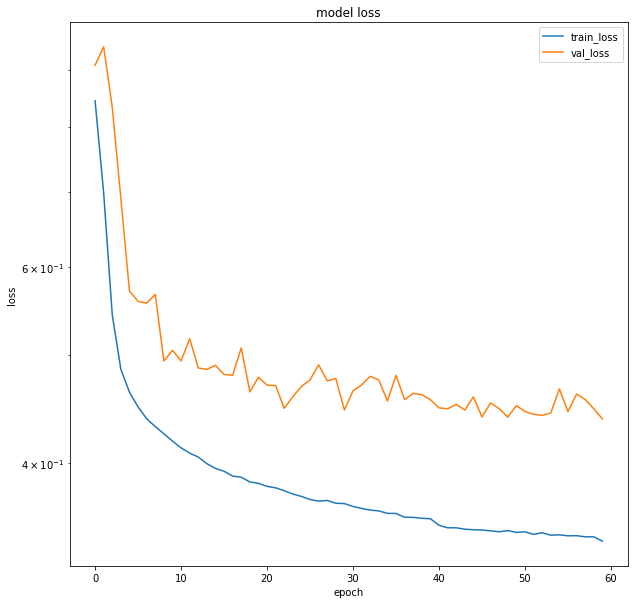

In [15]:
plt.figure(figsize=(10, 10))
plt.semilogy(model.history.history['loss'])
plt.semilogy(model.history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train_loss', 'val_loss'], loc='upper right');

In [16]:
import time
from sklearn.metrics import classification_report
start = time.time()
val_gen = plain_net_eddy(batch_size, img_size, val_input, val_target)
val_preds = model.predict(val_gen)
print(val_preds.shape)

end = time.time()
time_per_img = (end - start)/1655
print("Time Per image:",time_per_img)
print("Time for 1 year eqv:",time_per_img*365)

(576, 65536, 3)
Time Per image: 0.0034774614604938425
Time for 1 year eqv: 1.2692734330802524


In [17]:
# val_gen = plain_net_eddy(batch_size, img_size, val_input, val_target)
# mask = np.expand_dims(val_preds, axis=-1)
val_gen = data_x[0]
val_gen = np.reshape(val_gen,(1,img_size[0],img_size[1],1))
print(val_gen.shape)
val_preds = model.predict(val_gen)
print(val_preds.shape)
mask = np.argmax(np.reshape(val_preds[0],(1,img_size[1],img_size[0],3)), axis=-1)
mask = np.reshape(mask,(img_size[0],img_size[1]))
print(classification_report(np.reshape(data_y[80],(65536)),np.reshape(mask,(65536))))

(1, 256, 256, 1)
(1, 65536, 3)
              precision    recall  f1-score   support

         0.0       0.93      0.94      0.93     60136
         1.0       0.17      0.14      0.16      3040
         2.0       0.25      0.24      0.24      2360

    accuracy                           0.88     65536
   macro avg       0.45      0.44      0.44     65536
weighted avg       0.87      0.88      0.87     65536



<Figure size 1440x720 with 0 Axes>

<AxesSubplot:>

(-0.5, 255.5, 255.5, -0.5)

Text(0.5, 1.0, 'Result Segmentation')

<AxesSubplot:>

(-0.5, 255.5, 255.5, -0.5)

Text(0.5, 1.0, 'Groundtruth Segmentation')

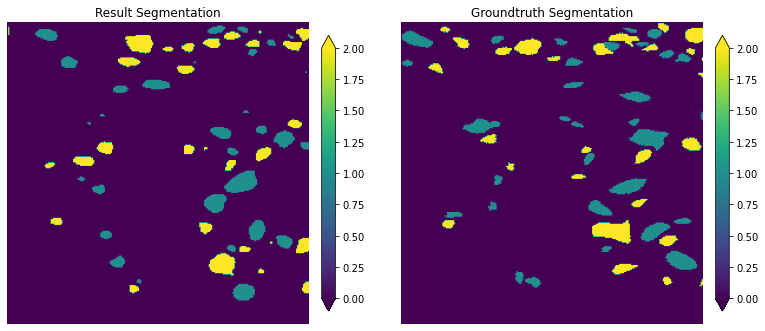

In [18]:
#seeing the prediction of one image of the validation set
%matplotlib inline

plt.figure(figsize=(20, 10))

plt.subplot(131)
plt.imshow(mask.T, cmap='viridis')
plt.colorbar(extend='both', fraction=0.042, pad=0.04)
plt.axis('off')
plt.title('Result Segmentation');
plt.savefig('prediction.png')

plt.subplot(132)
plt.imshow(data_y[80].T, cmap='viridis')
plt.colorbar(extend='both', fraction=0.042, pad=0.04)
plt.axis('off')
plt.title('Groundtruth Segmentation');
plt.savefig('groundtruth.png')